# The Power of Plots
### Matplotlib Homework Assignment
 Author: Alex Schanne

In this assignment, we will be working for Pymaceuticals Inc. on their most recent animal study. We will be generating all the tables and figures needed for the technical report of the study. Additionally we will provide a summary of our results at the end. 
<p>More specifically this report will:
<ul>
    <li> Clean all the data for duplicates.
    <li> Generate a statistical summary of the data, including mean, median, variance, standard deviation and SEM of the tumor volume in each drug regimen.
    <li> Use Panda's DataFrame and Matplotlib's Pyplot to visualize.
    <li> Calculate the final tumor volume of each mouse across the four most promising treatment regimens: Capomulin, Ramicane, Infubinol, and Ceftamin, in order to look at the quartiles and determine outliers.
    <li> Create a Box and Whiskers plot of the final tumor volume for all four treatment regimens and highlight any potential outliers in distict color and style. 
    <li> Select a Capomulin mouse and generate a plot of time versus tumor volume. 
    <li> Generate a scatter plot of mouse weight versus average tumor volume for Capomulin. And calculate the correlation coefficient and linear regression model for that relationship.
</ul>

## Trends and Observations

#### First Observation
The first thing we notice when we take a look at this study is the subject population. They carefully tried to keep the population half and half male-female and equal for each drug regimen. So at least superficially (without knowing any other attributes of the population) that the trial was trying to be 'fair' for each regimen. The only regimen that did not have 25 mouse subjects was Stelasyn.

#### Second Observation
Another immediate observation we can make about this data is from the data summary of tumor volume over time. We see that the variance in tumor volume is low to start but seem to increase throughout the timepoints. This is to be expected if we are to believe that the study was set up correctly and we are seeing how each mouse responds to the treatment idiosyncratically. In any experiment, setting the initial conditions, in this case ensuring approximately equal tumor volumes in the mice, will allow a better measurement of how different variables are affected by the controlled variables. 
<p>
For instance the mouse population in the Capomulin treatment group, show a 0.00 variance at timepoint 0, but by timepoint 45, they show a variance of 19.035028.

#### Third Observation
Another thing we notice is the range and skew of the weight data for the top two of the top four drugs seem to be smaller and lower. Or rather, their range is not as large. Neither Capomulin or Ramicane have outliers and their interquartile range is below 10, meaning the majority of the mice's weights data falls within 10 mm3 of each other. Additionally the mice of those regimen's weigh, on average, less than the mice of the other regimens. 

*This seems to suggest that lower weight is a positive outcome of the drug treatments. This is not explicitly stated. So it should be noted that this is only inferred. Any conclusions based on this assumption should be re-evaluated, and not be considered final. 

## Setting up and Cleaning the Data

In [1]:
#Importing dependencies and doing pre-work
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import plotly.graph_objects as go
import plotly.offline as pyo

#importing files and creating Dataframes
mouse_path = "data/Mouse_metadata.csv"
results_path = "data/Study_results.csv"

mouse_pd = pd.read_csv(mouse_path)
study_pd = pd.read_csv(results_path)


#merging dataframes into one, on 'Mouse ID'
stewart_little = pd.merge(mouse_pd, study_pd, on = "Mouse ID")

#Cleaning the columns names to ameliorate typing
mouse_study = stewart_little.rename(columns = {'Mouse ID': 'mouse_id', 
                                              'Drug Regimen': 'drug',
                                              'Sex': 'sex',
                                              'Age_months': 'age',
                                              'Weight (g)': 'weight',
                                              'Timepoint': 'timepoint',
                                              'Tumor Volume (mm3)': 'tumor_volume',
                                              'Metastatic Sites': 'metastatic_sites'})
mouse_study.head()

,mouse_id,drug,sex,age,weight,timepoint,tumor_volume,metastatic_sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [2]:
#Checking amount of data in study versus how many unique mouse ids are included in the study 
print(len(mouse_study), mouse_study['mouse_id'].nunique())

1893 249


In [3]:
#Checking the number of different drug regimens
mouse_study['drug'].value_counts()

Capomulin    230
Ramicane     228
Ketapril     188
Naftisol     186
Zoniferol    182
Stelasyn     181
Placebo      181
Infubinol    178
Ceftamin     178
Propriva     161
Name: drug, dtype: int64

In [4]:
#Dropping the duplicate mice rows and keeping their initial row
clean_complete = mouse_study.drop_duplicates(subset = 'mouse_id', keep = 'first', inplace = False) 
clean_complete.head()

,mouse_id,drug,sex,age,weight,timepoint,tumor_volume,metastatic_sites
0,k403,Ramicane,Male,21,16,0,45.0,0
10,s185,Capomulin,Female,3,17,0,45.0,0
20,x401,Capomulin,Female,16,15,0,45.0,0
30,m601,Capomulin,Male,22,17,0,45.0,0
40,g791,Ramicane,Male,11,16,0,45.0,0


In [5]:
print(clean_complete['mouse_id'].count())
print(clean_complete['drug'].value_counts())

249
Infubinol    25
Zoniferol    25
Ramicane     25
Propriva     25
Capomulin    25
Placebo      25
Ceftamin     25
Naftisol     25
Ketapril     25
Stelasyn     24
Name: drug, dtype: int64


## Summary Statistics

Now that we have created clean dataframes, combining the study results and the mice data, we will quickly go over a statistical summary of the data. That way we have a better understanding of the data's narrative and are better prepared to do more in-depth analysis later. 

In [6]:
#Generating a summary statistics table for the tumor volume for each regimen
drug_group = mouse_study.set_index("timepoint").groupby(['drug', 'timepoint']).agg({'tumor_volume': ['mean', 'median', 'var', 'std', 'sem']})
drug_group

tumor_volume                                          
                            mean     median        var       std       sem
drug      timepoint                                                       
Capomulin 0            45.000000  45.000000   0.000000  0.000000  0.000000
          5            44.266086  45.597064   5.030889  2.242964  0.448593
          10           43.084291  43.421014  12.344133  3.513422  0.702684
          15           42.064317  42.798160  16.878693  4.108369  0.838617
          20           40.716325  40.716428  19.035028  4.362915  0.909731
...                          ...        ...        ...       ...       ...
Zoniferol 25           55.432935  55.676604   5.808348  2.410052  0.602513
          30           57.713531  57.419744   9.601024  3.098552  0.800043
          35           60.089372  60.365832  10.876760  3.297993  0.881426
          40           62.916692  62.274543  13.958456  3.736102  0.998515
          45           65.960888  65.684689  14.100301  3.755037  1.003576

[100 rows x 5 columns]

## Bar and Pie Charts

Now that we have a clear summary of each drug's performance as measured by tumor volume (mm3), we can start to plot some of the key behaviors and trends we want to analyze. First we will visualize with Bar and Pie charts. 

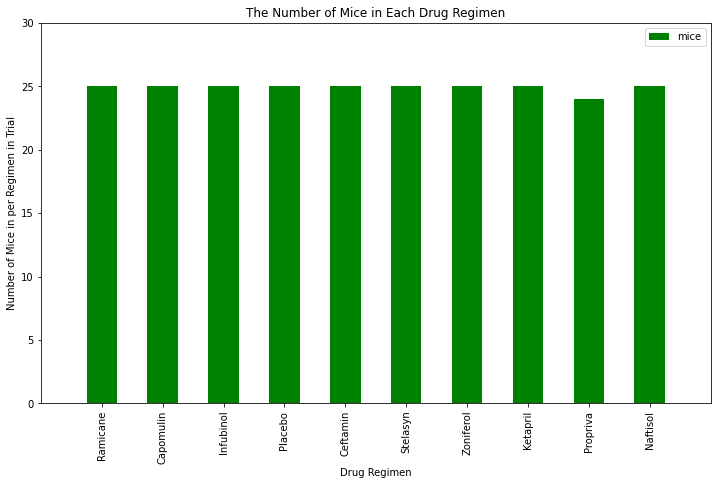

In [7]:
#Pandas: Generating a bar plot showing the total number of mice for each treatment throughout study.
#creating the dataframe
x_axis = clean_complete['drug'].unique().tolist()
y_axis = clean_complete.groupby(['drug'])['mouse_id'].count().tolist()
drug_mouse = pd.DataFrame({'drug':x_axis, 'mice': y_axis})

#creating the plot and formatting to match the last
subject_plot = drug_mouse.plot(kind = "bar", figsize = (12,7), color = 'g')

subject_plot.get_xticks()
subject_plot.set_xticklabels(drug_mouse['drug'])
subject_plot.set_title('The Number of Mice in Each Drug Regimen')
subject_plot.set_xlabel('Drug Regimen')
subject_plot.set_ylabel('Number of Mice in per Regimen in Trial')

subject_plot.set_xlim(-1, len(x_axis))
subject_plot.set_ylim(0, max(y_axis) + 5)

#saving and showing bar chart
plt.savefig('charts/drugsubjects_barchart1')
plt.show()

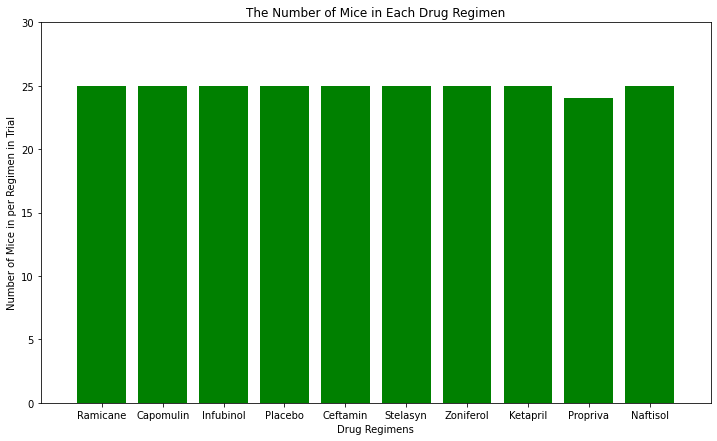

In [8]:
#Matplotlib: Generating a bar plot showing the total number of mice for each treatment throughout study.
x_axis = clean_complete['drug'].unique().tolist()
y_axis = clean_complete.groupby(['drug'])['mouse_id'].count().tolist()

#Creating and formatting the figure
plt.figure(figsize = (12,7))
plt.bar(x_axis, y_axis, color = 'g', align = 'center')
plt.xlabel("Drug Regimens")
plt.ylabel("Number of Mice in per Regimen in Trial")
plt.title("The Number of Mice in Each Drug Regimen")

plt.xlim(-1, len(x_axis))
plt.ylim(0, max(y_axis) + 5)

#saving and showing bar chart
plt.savefig('charts/drugsubjects_barchart2')
plt.show()

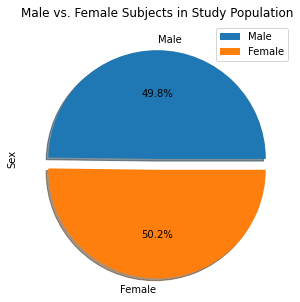

In [9]:
#Pandas: Generating a pie chart showing male vs female subjects for each treatment throughout study.
#the data to be used
gender_group = clean_complete.groupby(['sex']).count()[['mouse_id']]
labels = clean_complete['sex'].unique().tolist()

#creating the pie chart
gender_group.plot.pie(subplots = True, explode = (0, 0.1), labels = labels, autopct="%1.1f%%", figsize = (5,5), shadow = True)
plt.ylabel('Sex')
plt.title('Male vs. Female Subjects in Study Population')

#saving and showing pie chart
plt.savefig('charts/subjectsex_piechart1')
plt.show()

C:\Users\alexs\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



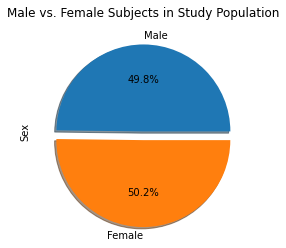

In [10]:
#Matplotlib: Generating a pie chart showing male vs female subjects for each treatment throughout study.
fig, ax = plt.subplots()
ax.pie(gender_group, explode = (0, 0.1), labels = labels, autopct="%1.1f%%", shadow = True)
ax.set_ylabel('Sex')
ax.set_title('Male vs. Female Subjects in Study Population')

#showing pie chart
plt.savefig('charts/subjectsex_piechart2')
plt.show()

## Quartiles, Outliers and Boxplots

Now that we have looked more closely at our study population, we move on to the data range. We will look at the skew of our data, where most of our data lies with its range and we will look to see if there are any outliers in our data. 

In [11]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
last_time = mouse_study.drop_duplicates(subset = 'mouse_id', keep = 'last', inplace = False) 

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
top4 = last_time[(last_time['drug'] == 'Capomulin') | (last_time['drug'] == 'Ramicane') | (last_time['drug'] == 'Infubinol') | (last_time['drug'] == 'Ceftamin')]
top4

,mouse_id,drug,sex,age,weight,timepoint,tumor_volume,metastatic_sites
9,k403,Ramicane,Male,21,16,45,22.050126,1
19,s185,Capomulin,Female,3,17,45,23.343598,1
29,x401,Capomulin,Female,16,15,45,28.484033,0
39,m601,Capomulin,Male,22,17,45,28.430964,1
49,g791,Ramicane,Male,11,16,45,29.128472,1
...,...,...,...,...,...,...,...,...
1797,x822,Ceftamin,Male,3,29,45,61.386660,3
1813,y163,Infubinol,Female,17,27,45,67.685569,3
1845,y769,Ceftamin,Female,6,27,45,68.594745,4
1855,y865,Ceftamin,Male,23,26,45,64.729837,3


In [21]:
# Put treatments into a list for for loop (and later for plot labels)
regimens = top4['drug'].tolist()

# Create empty list to fill with tumor vol data (for plotting)
vol_data = []
outlier_list = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
quartiles = top4['tumor_volume'].quantile([.25,.5,.75])
lowerq = quartiles[.25]
upperq = quartiles[.75]
iqr = upperq-lowerq

#Finding outliers with pandas function
def outliers(df): 
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    tum_vol = top4['tumor_volume']
    for volume in tum_vol:
        if volume > upper_bound or volume < lower_bound:
            outlier_list.append(volume)
            vol_data.append(volume)
        else:
            vol_data.append(volume)
    return outlier_list

outliers(top4)

#Printing out results of Quartile and Outlier Analysis
print(f"The lower quartile of the tumor volume data is: {lowerq}.")
print(f"The upper quartile of the tumor volume data is: {upperq}.")
print(f"The interquartile range of the tumor volume data is: {iqr}.")
print(f"The the median of the tumor volume data is: {quartiles[0.5]}.")
if len(outlier_list) != 0:
    print(f"The full dataset for tumor volume in all regimens contains the following outlier(s):" + str(outlier_list))
else:
    print("There are no outliers in the Tumor Volume data for the top four regimens.")

The lower quartile of the tumor volume data is: 37.187743802499995.
The upper quartile of the tumor volume data is: 59.930261755000004.
The interquartile range of the tumor volume data is: 22.74251795250001.
The the median of the tumor volume data is: 45.0.
There are no outliers in the Tumor Volume data for the top four regimens.


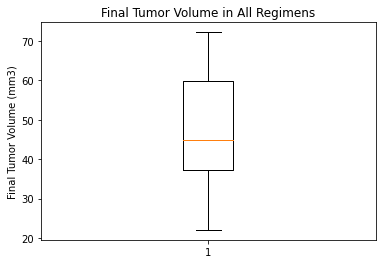

In [22]:
#This is a Box and Whiskers Plot for the data for all 4 regimens. It will be a guide for the 
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Final Tumor Volume in All Regimens')
ax1.set_ylabel('Final Tumor Volume (mm3)')
ax1.boxplot(vol_data, flierprops=green_diamond)
plt.show()

In [24]:
#Analyzing the Quartiles and Outliers of Capomulin
#Capomulin DataFrame
capo_data = top4[top4['drug'].isin(['Capomulin'])]

#Creating Empty lists for to loop through for plotting
capo_vol = []
capo_outliers = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
quartiles = capo_data['tumor_volume'].quantile([.25,.5,.75])
capo_lowerq = quartiles[.25]
capo_upperq = quartiles[.75]
capo_iqr = capo_upperq-capo_lowerq

#Finding outliers with pandas function
def outliers(df): 
    lower_bound = capo_lowerq - (1.5*capo_iqr)
    upper_bound = capo_upperq + (1.5*capo_iqr)
    tum_vol = capo_data['tumor_volume']
    for volume in tum_vol:
        if volume > upper_bound or volume < lower_bound:
            capo_outliers.append(volume)
            capo_vol.append(volume)
        else:
            capo_vol.append(volume)
    return capo_outliers

outliers(capo_data)

print(f"The lower quartile of Capomulin's tumor volume data is: {capo_lowerq}")
print(f"The upper quartile of Capomulin's tumor volume is: {capo_upperq}")
print(f"The interquartile range of Capomulin's tumor volume is: {capo_iqr}")
print(f"The the median of Capomulin's tumor volume is: {quartiles[0.5]} ")
if len(capo_outliers) != 0:
    print(f"The data for Capomulin contains the following outlier(s):" + str(capo_outliers))
else:
    print("There are no outliers in the Tumor Volume data for Capomulin.")

The lower quartile of Capomulin's tumor volume data is: 32.37735684
The upper quartile of Capomulin's tumor volume is: 40.1592203
The interquartile range of Capomulin's tumor volume is: 7.781863460000004
The the median of Capomulin's tumor volume is: 38.125164399999996 
There are no outliers in the Tumor Volume data for Capomulin.


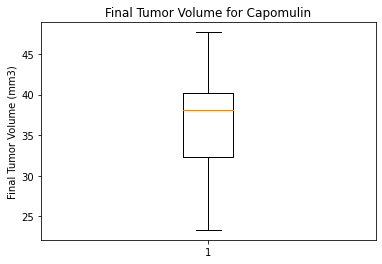

In [83]:
#Creating the Box and Whiskers plot for Capomulin
green_diamond = dict(markerfacecolor='g', marker='D')
fig2, ax2 = plt.subplots()
ax2.set_title('Final Tumor Volume for Capomulin')
ax2.set_ylabel('Final Tumor Volume (mm3)')
ax2.boxplot(capo_vol, flierprops=green_diamond)
plt.show()

In [27]:
#Analyzing the Quartiles and Outliers of Ramicane
#Ramicane DataFrame
rami_data = top4[top4['drug'].isin(['Ramicane'])]

#Creating Empty lists for to loop through for plotting
rami_vol = []
rami_outliers = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
quartiles = rami_data['tumor_volume'].quantile([.25,.5,.75])
rami_lowerq = quartiles[.25]
rami_upperq = quartiles[.75]
rami_iqr = rami_upperq-rami_lowerq

#Finding outliers with pandas function
def outliers(df): 
    lower_bound = rami_lowerq - (1.5*rami_iqr)
    upper_bound = rami_upperq + (1.5*rami_iqr)
    tum_vol = rami_data['tumor_volume']
    for volume in tum_vol:
        if volume > upper_bound or volume < lower_bound:
            rami_outliers.append(volume)
            rami_vol.append(volume)
        else:
            rami_vol.append(volume)
    return rami_outliers

outliers(rami_data)

print(f"The lower quartile of Ramicane's tumor volume data is: {rami_lowerq}")
print(f"The upper quartile of Ramicane's tumor volume data is: {rami_upperq}")
print(f"The interquartile range of Ramicane's tumor volume data is: {rami_iqr}")
print(f"The the median of Ramicane's tumor volume data is: {quartiles[0.5]} ")
if len(rami_outliers) != 0:
    print(f"The data for Ramicane contains the following outlier(s):" + str(rami_outliers))
else: print("There are no outliers in the Tumor Volume data for Ramicane.")

The lower quartile of Ramicane's tumor volume data is: 31.56046955
The upper quartile of Ramicane's tumor volume data is: 40.65900627
The interquartile range of Ramicane's tumor volume data is: 9.098536719999998
The the median of Ramicane's tumor volume data is: 36.56165229 
There are no outliers in the Tumor Volume data for Ramicane.


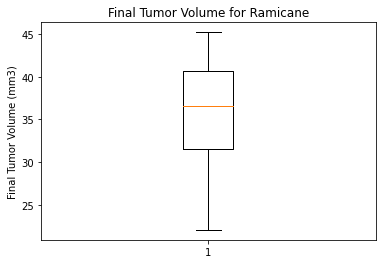

In [28]:
#Creating the Box and Whiskers plot for Ramicane
green_diamond = dict(markerfacecolor='g', marker='D')
fig3, ax3 = plt.subplots()
ax3.set_title('Final Tumor Volume for Ramicane')
ax3.set_ylabel('Final Tumor Volume (mm3)')
ax3.boxplot(rami_vol, flierprops=green_diamond)
plt.show()

In [29]:
#Analyzing the Quartiles and Outliers of Infubinol
#Infubinol DataFrame
infu_data = top4[top4['drug'].isin(['Infubinol'])]

#Creating Empty lists for to loop through for plotting
infu_vol = []
infu_outliers = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
quartiles = infu_data['tumor_volume'].quantile([.25,.5,.75])
infu_lowerq = quartiles[.25]
infu_upperq = quartiles[.75]
infu_iqr = infu_upperq-infu_lowerq

#Finding outliers with pandas function
def outliers(df): 
    lower_bound = infu_lowerq - (1.5*infu_iqr)
    upper_bound = infu_upperq + (1.5*infu_iqr)
    tum_vol = infu_data['tumor_volume']
    for volume in tum_vol:
        if volume > upper_bound or volume < lower_bound:
            infu_outliers.append(volume)
            infu_vol.append(volume)
        else:
            infu_vol.append(volume)
    return infu_outliers

outliers(infu_data)

print(f"The lower quartile of Infubinol's tumor volume data is: {infu_lowerq}")
print(f"The upper quartile of Infubinol's tumor volume data is: {infu_upperq}")
print(f"The interquartile range of Infubinol's tumor volume data is: {infu_iqr}")
print(f"The the median of Infubinol's tumor volume data is: {quartiles[0.5]} ")
if len(infu_outliers) != 0:
    print(f"The data for Infubinol contains the following outlier(s):" + str(infu_outliers))
else: print("There are no outliers in the Tumor Volume data for Infubinol.")

The lower quartile of Infubinol's tumor volume data is: 54.04860769
The upper quartile of Infubinol's tumor volume data is: 65.52574285
The interquartile range of Infubinol's tumor volume data is: 11.477135160000003
The the median of Infubinol's tumor volume data is: 60.16518046 
The data for Infubinol contains the following outlier(s):[36.321345799999996]


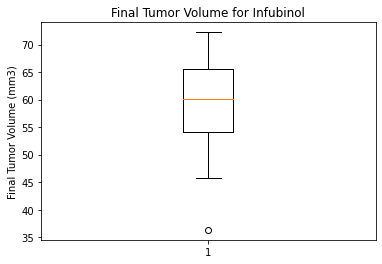

In [30]:
#Creating the Box and Whiskers plot for Infubinol
green_diamond = dict(markerfacecolor='g', marker='D')
fig4, ax4 = plt.subplots()
ax4.set_title('Final Tumor Volume for Infubinol')
ax4.set_ylabel('Final Tumor Volume (mm3)')
ax4.boxplot(infu_vol, showfliers=green_diamond)
plt.show()

In [31]:
#Analyzing the Quartiles and Outliers of Ceftamin
#Ceftamin DataFrame
ceft_data = top4[top4['drug'].isin(['Ceftamin'])]

#Creating Empty lists for to loop through for plotting
ceft_vol = []
ceft_outliers = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
quartiles = ceft_data['tumor_volume'].quantile([.25,.5,.75])
ceft_lowerq = quartiles[.25]
ceft_upperq = quartiles[.75]
ceft_iqr = ceft_upperq-ceft_lowerq

#Finding outliers with pandas function
def outliers(df): 
    lower_bound = ceft_lowerq - (1.5*ceft_iqr)
    upper_bound = ceft_upperq + (1.5*ceft_iqr)
    tum_vol = ceft_data['tumor_volume']
    for volume in tum_vol:
        if volume > upper_bound or volume < lower_bound:
            ceft_outliers.append(volume)
            ceft_vol.append(volume)
        else:
            ceft_vol.append(volume)
    return ceft_outliers

outliers(ceft_data)

print(f"The lower quartile of Ceftamin's tumor volume data is: {ceft_lowerq}")
print(f"The upper quartile of Ceftamin's tumor volume data is: {ceft_upperq}")
print(f"The interquartile range of Ceftamin's tumor volume data is: {ceft_iqr}")
print(f"The the median of Ceftamin's tumor volume data is: {quartiles[0.5]} ")
if len(ceft_outliers) != 0:
    print(f"The data for Ceftamin contains the following outlier(s):" + str(ceft_outliers))
else: print("There are no outliers in the Tumor Volume data for Ceftamin.")

The lower quartile of Ceftamin's tumor volume data is: 48.72207785
The upper quartile of Ceftamin's tumor volume data is: 64.29983003
The interquartile range of Ceftamin's tumor volume data is: 15.577752179999997
The the median of Ceftamin's tumor volume data is: 59.85195552 
There are no outliers in the Tumor Volume data for Ceftamin.


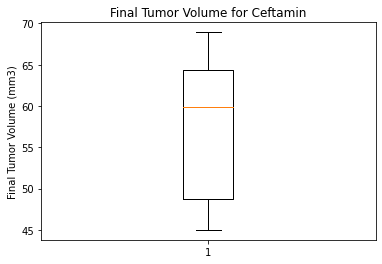

In [32]:
#Creating the Box and Whiskers plot for Ceftamin
green_diamond = dict(markerfacecolor='g', marker='D')
fig4, ax5 = plt.subplots()
ax5.set_title('Final Tumor Volume for Ceftamin')
ax5.set_ylabel('Final Tumor Volume (mm3)')
ax5.boxplot(ceft_vol, showfliers=green_diamond)
plt.show()

In [34]:
#Combining the box and whiskers into one plot using plotly (just to try- found it while working on the homework)
trace0 = go.Box(
        y = capo_vol,
        name = "Capomulin"
)
trace1 = go.Box(
        y = rami_vol,
        name = "Ramicane"
)
trace2 = go.Box(
        y = infu_vol,
        name = "Infubinol"
)
trace3 = go.Box(
        y = ceft_vol,
        name = "Ceftamin"
)
data = [trace0, trace1, trace2, trace3]
layout = go.Layout(title = "Final Tumor Volume (mm3) for the Top Four Drug Regimens")
fig = go.Figure(data=data, layout=layout)
pyo.plot(fig)

'temp-plot.html'

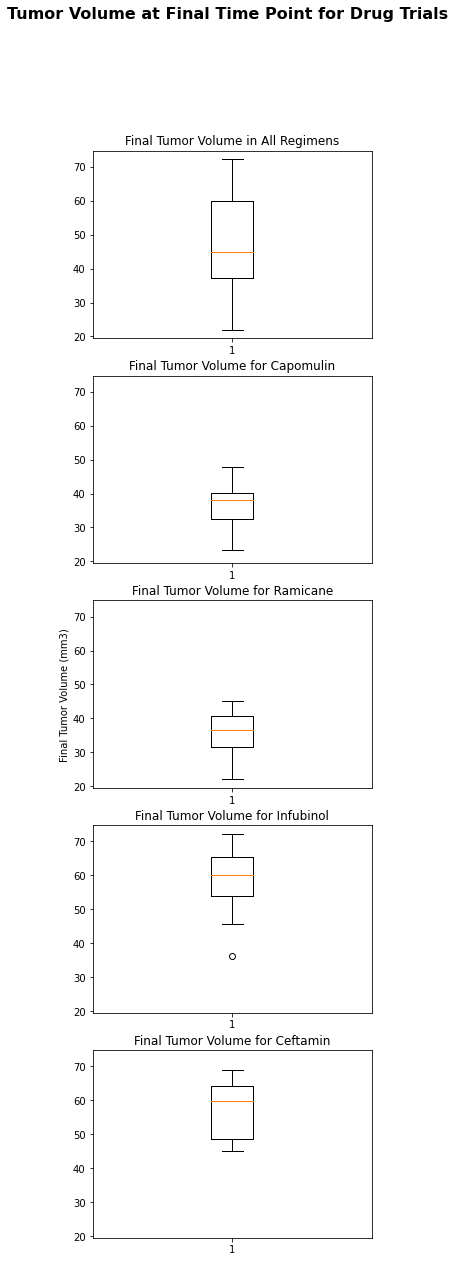

In [104]:
#Combining plots using matplotlib
#formatting outliers
green_diamond = dict(markerfacecolor='g', marker='D')

#Creating the figure
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize = (5,20), sharex = True, sharey = True)
fig.suptitle("Tumor Volume at Final Time Point for Drug Trials", fontsize = 16, fontweight = "bold")

ax1 = plt.subplot(511)
ax1.set_title('Final Tumor Volume in All Regimens')
ax1.boxplot(vol_data, flierprops=green_diamond)

ax2 = plt.subplot(512, sharey = ax1)
ax2.set_title('Final Tumor Volume for Capomulin')
ax2.boxplot(capo_vol, flierprops=green_diamond)

ax3 = plt.subplot(513, sharey = ax1)
ax3.set_title('Final Tumor Volume for Ramicane')
ax3.set_ylabel('Final Tumor Volume (mm3)')
ax3.boxplot(rami_vol, flierprops=green_diamond)

ax4 = plt.subplot(514, sharey = ax1)
ax4.set_title('Final Tumor Volume for Infubinol')
ax4.boxplot(infu_vol, showfliers=green_diamond)

ax5 = plt.subplot(515, sharey = ax1)
ax5.set_title('Final Tumor Volume for Ceftamin')
ax5.boxplot(ceft_vol, showfliers=green_diamond)

#Save and Show plot
plt.savefig('charts/tumorvol_boxplots')
plt.show()

## Line and Scatter Plots

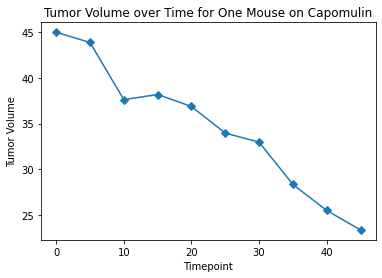

In [105]:
 # Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin

# Filter original data for just the Capomulin Drug Regime
capomulin_mice = mouse_study.loc[(mouse_study["drug"] == "Capomulin"),:]
capomulin_mouse = capomulin_mice.loc[(capomulin_mice['mouse_id'] == 's185'),:]

# Set variables to hold relevant data
timept = capomulin_mouse["timepoint"]
tumor_vol = capomulin_mouse["tumor_volume"]

# Plot the tumor volume for various mice
tumor_volume_line, = plt.plot(timept, tumor_vol, marker = 'D')

# Show the chart, add labels
plt.xlabel('Timepoint')
plt.ylabel('Tumor Volume')
plt.title('Tumor Volume over Time for One Mouse on Capomulin')

#Save and show figure
plt.savefig('charts/capomouse_tumvol_vs_time')
plt.show()

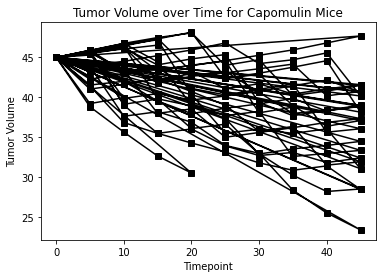

In [106]:
 # Generate a line plot of time point versus tumor volume for the mice treated with Capomulin

# Filter original data for just the Capomulin Drug Regime
capomulin_mice = mouse_study.loc[(mouse_study["drug"] == "Capomulin"),:]

# Set variables to hold relevant data
timept = capomulin_mice["timepoint"]
tumor_vol = capomulin_mice["tumor_volume"]

# Plot the tumor volume for various mice
tumor_volume_line, = plt.plot(timept, tumor_vol, marker = 's', color = 'black')

# Show the chart, add labels
plt.xlabel('Timepoint')
plt.ylabel('Tumor Volume')
plt.title('Tumor Volume over Time for Capomulin Mice')

#Save and show plot
plt.savefig('charts/capomice_tumvol_vs_time')
plt.show()

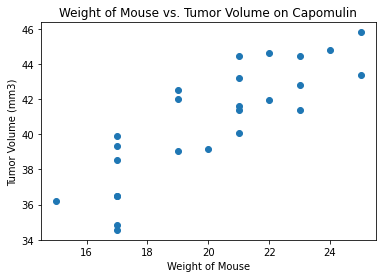

In [107]:
 # Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen

# Pull values for x and y values
mouse_weight = capomulin_mice.groupby(capomulin_mice["mouse_id"])["weight"].mean()
tumor_volume = capomulin_mice.groupby(capomulin_mice["mouse_id"])["tumor_volume"].mean()

# Create Scatter Plot with values calculated above
plt.scatter(mouse_weight,tumor_volume)
plt.xlabel("Weight of Mouse")
plt.ylabel("Tumor Volume (mm3)")
plt.title("Weight of Mouse vs. Tumor Volume on Capomulin")

#Save and show plot
plt.savefig('charts/weight_vs_tumvol_scatter')
plt.show()

The graph above is a scatterplot of the mice through all the timepoints during the Capomulin trial, so the mean of their weight and the tumor volume is an average for the entirety of the trial and therefore may not be representative of any specific time point. As we see in the previous line chart of weight over time in the trial, weight fluctuate drastically throughout the trial. What we can see from this graph is that there seems to be a positive correlation between weight of the mouse and tumor volume throughout the trial.

## Correlation and Regression

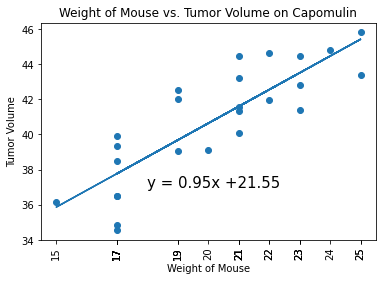

The correlation between weight and tumor value is 0.84


In [108]:
 # Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen 

# Pull values for x and y values
mouse_weight = capomulin_mice.groupby(capomulin_mice["mouse_id"])["weight"].mean()
tumor_vol = capomulin_mice.groupby(capomulin_mice["mouse_id"])["tumor_volume"].mean()

# Perform a linear regression on tumor volume versus mouse weight
slope, int, r, p, std_err = st.linregress(mouse_weight, tumor_vol)
      
# Create equation of line to calculate predicted weight
fit = slope * mouse_weight + int
line_eq = 'y = ' +str(round(slope,2)) + 'x +' + str(round(int,2))

# Plot the linear model on top of scatter plot 
plt.scatter(mouse_weight,tumor_vol)
plt.xlabel("Weight of Mouse")
plt.ylabel("Tumor Volume")
plt.title("Weight of Mouse vs. Tumor Volume on Capomulin")
plt.plot(mouse_weight,fit,"-")
plt.annotate(line_eq, (18,37), fontsize=15)
plt.xticks(mouse_weight, rotation=90)

#save and show plot
plt.savefig('charts/weight_vs_tumvol_regress')
plt.show()

# Caculate correlation coefficient
corr = round(st.pearsonr(mouse_weight,tumor_vol)[0],2)
print(f'The correlation between weight and tumor value is {corr}')